In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import re
from datetime import datetime, timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from IPython.display import HTML, display
from loguru import logger

In [3]:
sns.set_theme(style="whitegrid")

## Data preparation

In [4]:
# TODO: pandera schemas for input data

In [5]:
shoes_data = pl.read_csv("./data/run-tracker/Sheet 1-Shoes.csv").select(
    "UUID", "brand", "model"
)
shoes_order = shoes_data["UUID"].to_list()
shoes_data = shoes_data.with_columns(pl.col("UUID").cast(pl.Enum(shoes_order)))
shoes_data.head()

UUID,brand,model
enum,str,str
"""B001""","""Brooks""","""Ghost 10"""
"""B002""","""Brooks""","""Ghost 11"""
"""B003""","""Brooks""","""Ravenna 11"""
"""B004""","""Brooks""","""Ghost 13"""
"""B005""","""Brooks""","""Ghost 13"""


In [6]:
def _parse_duration(duration_str: str) -> timedelta:
    values = [x.strip() for x in duration_str.split(" ")]
    assert len(values) == 3, f"Unexpected duration format: {duration_str}"
    return timedelta(
        hours=int(values[0].split("h")[0]),
        minutes=int(values[1].split("m")[0]),
        seconds=int(values[2].split("s")[0]),
    )


runs_data = (
    pl.read_csv("./data/run-tracker/Sheet 1-Runs.csv")
    .filter(pl.col("Distance").is_not_null())
    .with_columns(pl.col("Shoe").cast(pl.Enum(shoes_order)))
    .join(shoes_data, left_on="Shoe", right_on="UUID", how="left")
    .with_columns(
        pl.col("Notes").fill_null(""),
        pl.col("Datetime").map_elements(
            lambda x: datetime.strptime(re.sub(r"\u202f", " ", x), "%m/%d/%y %H:%M %p"),
            return_dtype=pl.Datetime,
        ),
        pl.col("Total duration").map_elements(
            _parse_duration, return_dtype=pl.Duration
        ),
        pl.col("Time running").map_elements(_parse_duration, return_dtype=pl.Duration),
    )
    .with_columns(
        pl.col("Time running")
        .map_elements(lambda x: x.total_seconds() / 60, return_dtype=pl.Float64)
        .alias("time_running_minutes"),
        pl.col("Total duration")
        .map_elements(lambda x: x.total_seconds() / 60, return_dtype=pl.Float64)
        .alias("total_duration_minutes"),
    )
    .with_columns(
        (pl.col("total_duration_minutes") / pl.col("Distance")).alias(
            "total_duration_pace"
        ),
        (pl.col("time_running_minutes") / pl.col("Distance")).alias(
            "time_running_pace"
        ),
    )
    .with_columns(
        pl.col("Notes")
        .str.to_lowercase()
        .str.contains("commuting")
        .alias("is_commuting_run")
    )
)
runs_data.head()

Shoe,Datetime,Distance,Time running,Total duration,Avg. pace,Conditions,Windy,Temp. (F),Humidity (%),Location,Notes,brand,model,time_running_minutes,total_duration_minutes,total_duration_pace,time_running_pace,is_commuting_run
enum,datetime[μs],f64,duration[μs],duration[μs],str,str,bool,i64,i64,str,str,str,str,f64,f64,f64,f64,bool
"""B008""",2024-09-02 03:03:00,5.02,null,40m 28s,"""0h 8m 4s""",null,null,null,null,"""629 Tremont""","""""","""Brooks""","""Ghost 14""",null,40.466667,8.061089,null,false
"""B008""",2024-09-04 06:56:00,3.55,null,30m 22s,"""0h 8m 33s""","""Clear""",null,54,82,"""629 Tremont""","""""","""Brooks""","""Ghost 14""",null,30.366667,8.553991,null,false
"""B008""",2024-09-04 04:22:00,3.04,null,26m 9s,"""0h 8m 36s""","""Clear""",null,75,43,"""Leiden Center 1""","""""","""Brooks""","""Ghost 14""",null,26.15,8.601974,null,false
"""B008""",2024-09-10 07:23:00,7.35,null,55m 40s,"""0h 7m 34s""",null,null,null,null,"""Fan Pier""","""""","""Brooks""","""Ghost 14""",null,55.666667,7.573696,null,false
"""B008""",2024-09-12 06:50:00,3.54,null,29m 5s,"""0h 8m 13s""","""Clear""",null,54,85,"""629 Tremont""","""""","""Brooks""","""Ghost 14""",null,29.083333,8.215631,null,false


In [7]:
TODAY = datetime.now()
for dt in runs_data["Datetime"]:
    if dt > TODAY:
        logger.error(f"Datetime in the future: {dt}")
        raise ValueError("Datetime in the future found in data")

In [14]:
MARATHON_TRAINING_STARTDATE = runs_data.filter(
    pl.col("Notes").str.to_lowercase() == "start marathon training"
)["Datetime"][0]
logger.info(f"Starting marathon training: {MARATHON_TRAINING_STARTDATE}")

MARATHON_TRAINING_ENDDATE = datetime(year=2025, month=7, day=19, hour=7, minute=48)
logger.info(f"Finished marathon training: {MARATHON_TRAINING_ENDDATE}")

2026-01-03 08:06:51.256 | INFO     | __main__:<module>:4 - Starting marathon training: 2025-04-08 10:49:00
2026-01-03 08:06:51.256 | INFO     | __main__:<module>:7 - Finished marathon training: 2025-07-19 07:48:00


In [15]:
runs_data = runs_data.with_columns(
    (
        (pl.col("Datetime") >= MARATHON_TRAINING_STARTDATE)
        & (pl.col("Datetime") <= MARATHON_TRAINING_ENDDATE)
    ).alias("is_marathon_training")
)

## Analysis

In [16]:
myFmt = mdates.DateFormatter("%m/%d")

In [17]:
def display_df(df: pl.DataFrame | pd.DataFrame) -> None:
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()
    display(HTML(df.to_html()))

### Shoes

,Shoe,brand,model,total_duration_minutes,Distance,total_duration_hours
0,B007,Brooks,Ghost 14,285.083333,34.32,4.751389
1,B008,Brooks,Ghost 14,1861.616667,224.25,31.026944
2,B009,Brooks,Cascadia,642.266667,56.49,10.704444
3,N001,New Balance,1080 (v14),3400.100000,427.46,56.668333
4,B010,Brooks,Ghost 16,1284.133333,162.42,21.402222
5,T001,Topo Athletic,Ultraventure 4,225.183333,23.07,3.753056


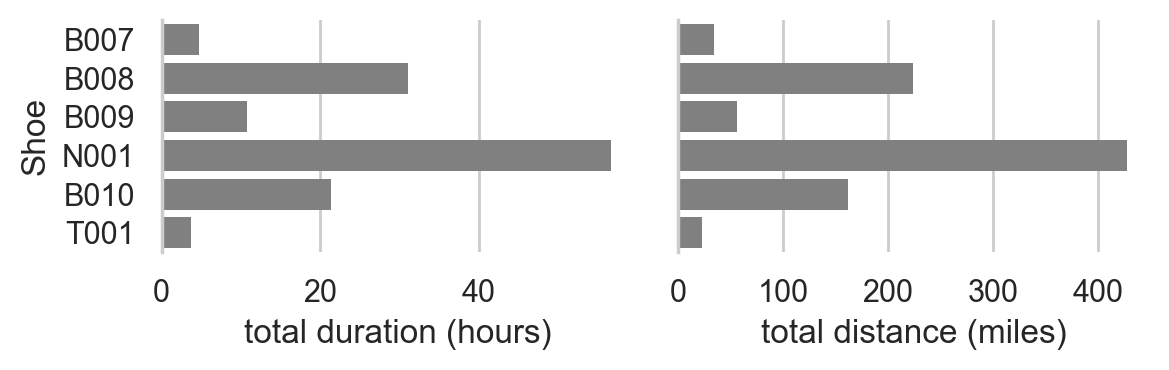

In [18]:
plot_data = (
    runs_data.group_by("Shoe", "brand", "model")
    .agg(pl.col("total_duration_minutes").sum(), pl.col("Distance").sum())
    .sort(
        "Shoe",
    )
    .with_columns((pl.col("total_duration_minutes") / 60).alias("total_duration_hours"))
    .to_pandas()
)
plot_data["Shoe"] = plot_data["Shoe"].cat.remove_unused_categories()

display_df(plot_data)

fig, axes = plt.subplots(ncols=2, figsize=(6, 2), squeeze=True, sharey=True)
sns.barplot(
    plot_data,
    y="Shoe",
    x="total_duration_hours",
    ax=axes[0],
    linewidth=0,
    color="gray",
)
axes[0].set_xlabel("total duration (hours)")
sns.barplot(plot_data, y="Shoe", x="Distance", ax=axes[1], linewidth=0, color="gray")
axes[1].set_xlabel("total distance (miles)")
for ax in axes:
    sns.despine(ax=ax, left=False, bottom=True)
fig.tight_layout()
plt.show()

### Marathon training

Nnumber of total hours and distance when training for my 2025 marathon.

In [20]:
runs_data.filter(pl.col("is_marathon_training")).with_columns(
    (pl.col("total_duration_minutes") / 60).alias("total_duration_hours").round(2)
).group_by("is_marathon_training").agg(
    pl.col("total_duration_hours").sum(), pl.col("Distance").sum()
).drop("is_marathon_training").rename(
    {"total_duration_hours": "hours run", "Distance": "distance"}
)

hours run,distance
f64,f64
51.35,386.91


Marathon training runs:

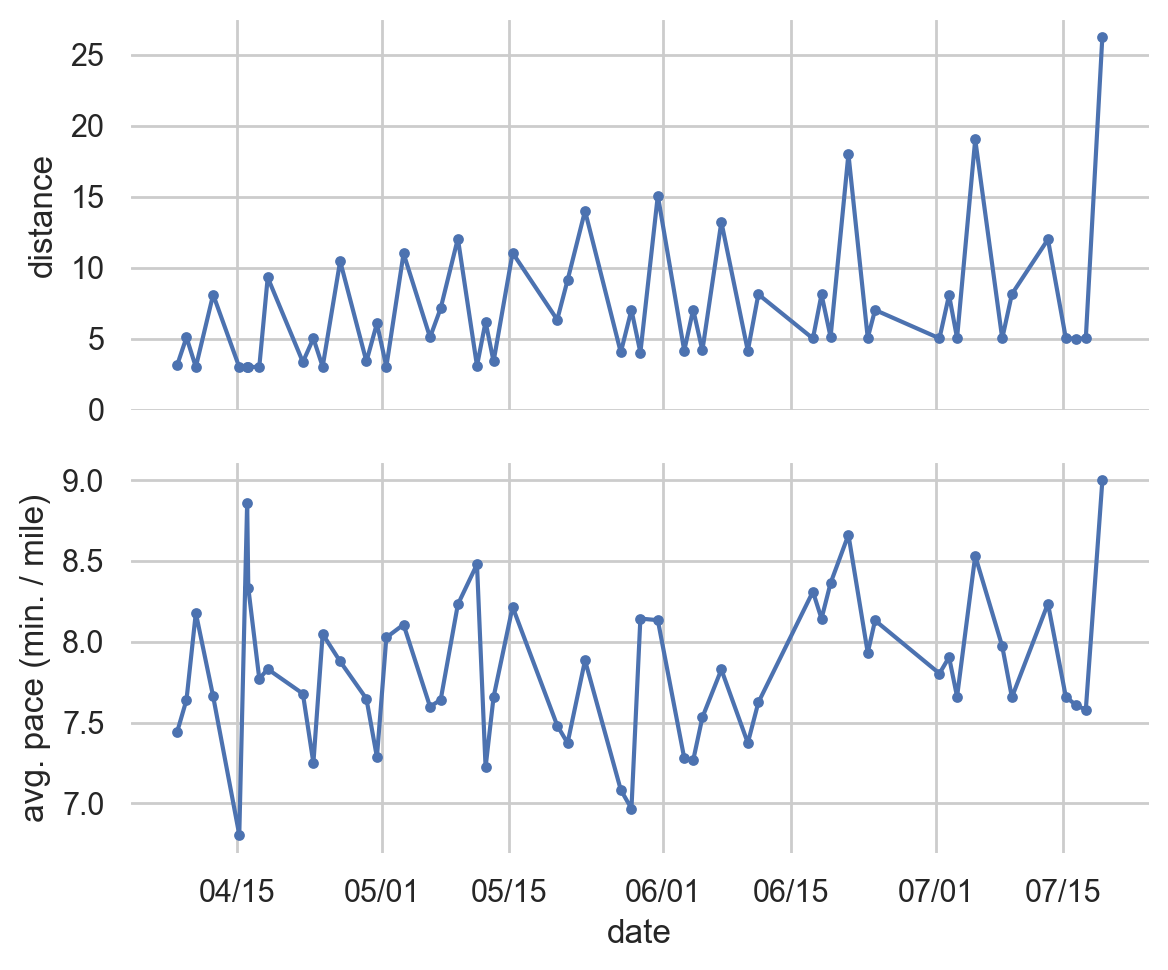

In [21]:
plot_data = runs_data.filter(pl.col("is_marathon_training")).to_pandas()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), squeeze=True, sharex=True)

sns.lineplot(plot_data, x="Datetime", y="Distance", ax=axes[0])
sns.scatterplot(plot_data, x="Datetime", y="Distance", ax=axes[0], linewidth=0, s=15)
axes[0].set_ylim(0, None)
axes[0].set_ylabel("distance")

sns.lineplot(plot_data, x="Datetime", y="total_duration_pace", ax=axes[1])
sns.scatterplot(
    plot_data, x="Datetime", y="total_duration_pace", ax=axes[1], linewidth=0, s=15
)
axes[1].set_ylabel("avg. pace (min. / mile)")
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].set_xlabel("date")

for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)
fig.tight_layout()
plt.show()

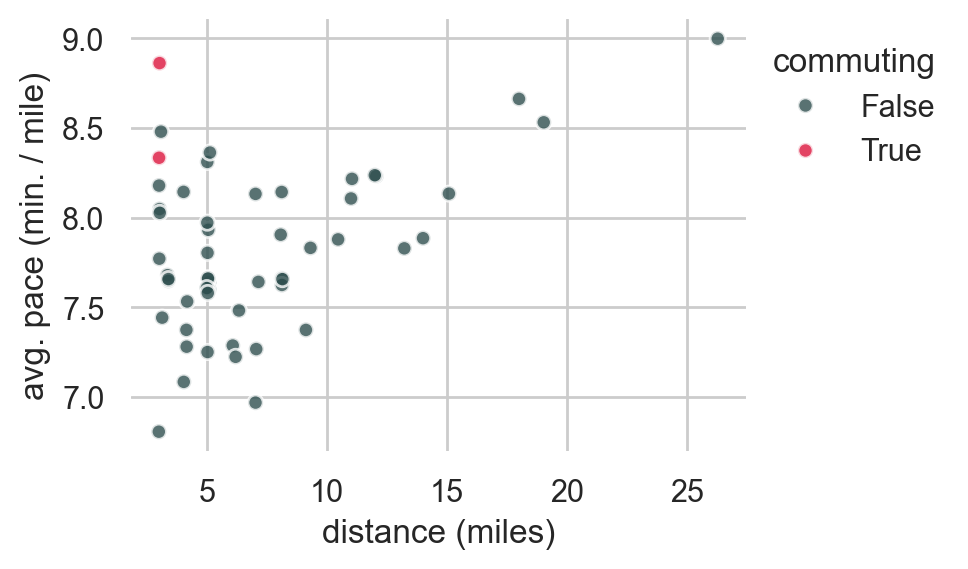

In [22]:
plot_data = runs_data.filter(pl.col("is_marathon_training")).to_pandas()

fig, ax = plt.subplots(figsize=(5, 3))
sns.scatterplot(
    plot_data,
    x="Distance",
    y="total_duration_pace",
    linewidth=1,
    s=30,
    hue="is_commuting_run",
    ax=ax,
    alpha=0.8,
    palette={True: "crimson", False: "darkslategray"},
)
sns.despine(ax=ax, left=True, bottom=True)
sns.move_legend(
    ax,
    "upper left",
    bbox_to_anchor=(1, 1),
    title="commuting",
    ncols=1,
    edgecolor="white",
)
ax.set_ylabel("avg. pace (min. / mile)")
ax.set_xlabel("distance (miles)")
fig.tight_layout()
plt.show()

### Other viz

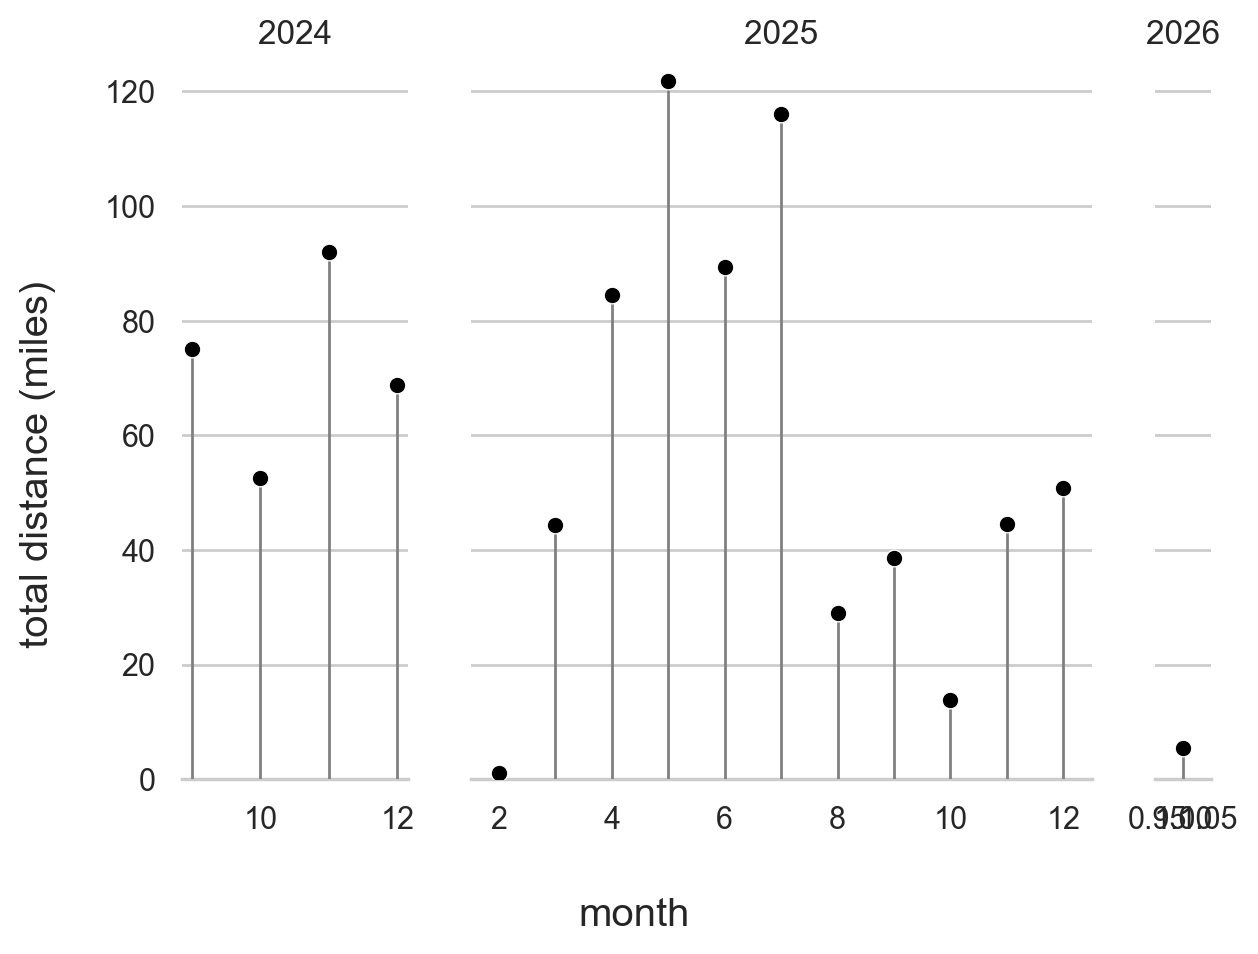

In [ ]:
# TODO: add all combinations of year and month to account for 0 months

plot_data = (
    runs_data.with_columns(
        pl.col("Datetime").dt.month().alias("month"),
        pl.col("Datetime").dt.year().alias("year"),
    )
    .select("month", "year", "Distance")
    .group_by("month", "year")
    .sum()
    .sort("year", "month")
)
n_years = plot_data["year"].n_unique()
n_months_per_year = (
    plot_data.select("year", "month")
    .unique(maintain_order=True)
    .group_by("year", maintain_order=True)
    .len()["len"]
    .to_numpy()
)
fig, axes = plt.subplots(
    nrows=1, ncols=n_years, width_ratios=n_months_per_year, sharey=True
)
for yr, ax in zip(plot_data["year"].unique(maintain_order=True), axes.flatten()):
    yr_plot_data = plot_data.filter(pl.col("year") == yr).to_pandas()
    ax.vlines(
        x=yr_plot_data["month"].to_numpy(),
        ymin=0,
        ymax=yr_plot_data["Distance"].to_numpy(),
        color="gray",
        linewidth=1,
        zorder=10,
    )
    sns.scatterplot(yr_plot_data, x="month", y="Distance", c="black", ax=ax, zorder=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(yr)
    ax.set_ylim(0, plot_data["Distance"].max() * 1.03)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

fig.supxlabel("month")
fig.supylabel("total distance (miles)")

sns.despine(fig=fig, left=True)

fig.tight_layout()
plt.show()


---

## Session information

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m